In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os

# Data Read

In [ ]:
data_dir = "C:\\Users\\yy\\cell_images"
train_path = data_dir + "\\train\\"
test_path = data_dir  + "\\test\\"

In [13]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [14]:
os.listdir(train_path)

['parasitized', 'uninfected']

# Samples of Dataset

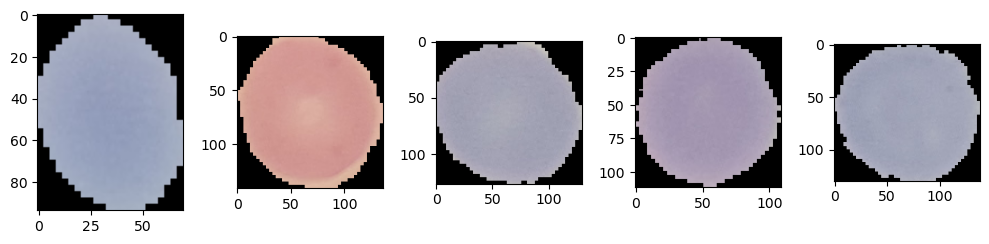

In [200]:
def show_samples(path: str, sample: int) -> None:
    index_arr = np.random.randint(0, 1000, sample)
    plt.figure(figsize = (10, 5))
    for i, j in enumerate(list(index_arr)):
        plt.subplot(1, sample, i + 1)
        plt.imshow(imread(path + os.listdir(path)[j]))
        plt.tight_layout()
        
show_samples(path = test_path + "uninfected\\", sample=5)

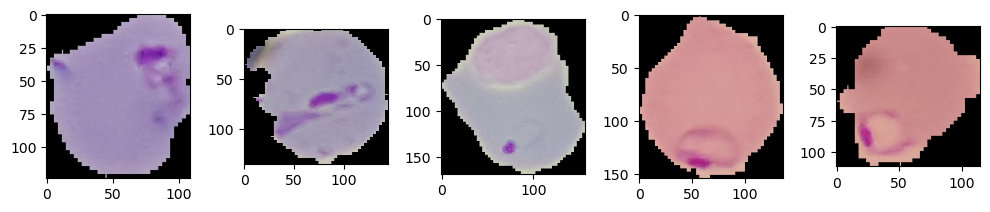

In [201]:
show_samples(path = test_path + "parasitized\\", sample=5)

In [93]:
print(f"File count: train_parasitized: {len(os.listdir(train_path + 'parasitized'))}")
print(f"File count: train_uninfected: {len(os.listdir(train_path + 'uninfected'))}")
print(f"File count: test_parasitized: {len(os.listdir(test_path + 'parasitized'))}")
print(f"File count: test_uninfected: {len(os.listdir(test_path + 'uninfected'))}")


File count: train_parasitized: 12480
File count: train_uninfected: 12480
File count: test_parasitized: 1300
File count: test_uninfected: 1300


# Adjusting Image Dimensions

In [98]:
dims = []

for img_file_name in os.listdir(test_path + "uninfected"):
    img = imread(test_path + "uninfected\\" + img_file_name)
    d1, d2, _ = img.shape
    dims.append((d1, d2))

In [99]:
dims_table = pd.DataFrame(dims, columns = ["dim1", "dim2"])

In [45]:
dims_table.mean(axis = 0)

dim1    130.925385
dim2    130.750000
dtype: float64

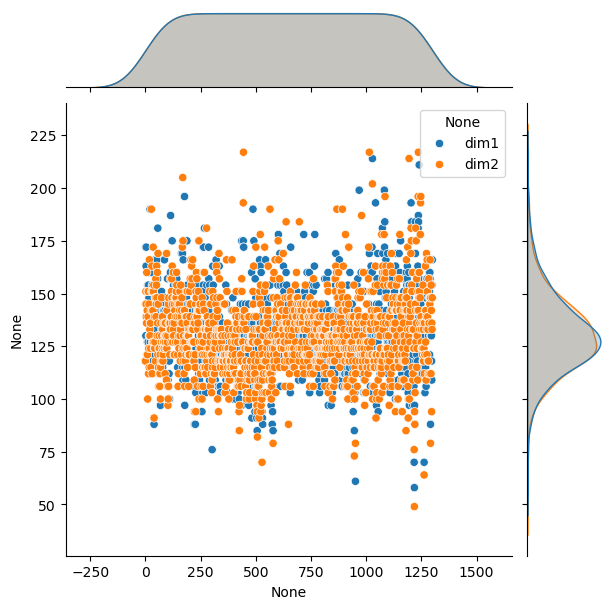

In [205]:
sns.jointplot(data = dims_table)

In [46]:
image_shape = (130, 130 , 3)

In [102]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Generator

In [ ]:
image_gen = ImageDataGenerator(
    rotation_range = 20, 
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest"
    )

In [152]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [153]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


# Building Model

In [156]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout



model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = image_shape, activation = "relu"))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), input_shape = image_shape, activation = "relu"))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), input_shape = image_shape, activation = "relu"))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.50))

model.add(Dense(1, activation = "sigmoid"))

model.compile(
    loss = "binary_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"]
)
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)      

In [157]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor = "val_loss", patience = 5)

In [166]:
batch_size = 250

In [167]:
train_image_gen = image_gen.flow_from_directory(train_path, 
                                                target_size=image_shape[:2], 
                                                color_mode = "rgb", 
                                                batch_size = batch_size, 
                                                class_mode="binary")


Found 24958 images belonging to 2 classes.


In [168]:
test_image_gen = image_gen.flow_from_directory(
    test_path, 
    target_size=image_shape[:2], 
    color_mode = "rgb", 
    batch_size = batch_size, 
    class_mode="binary", 
    shuffle=False)

Found 2600 images belonging to 2 classes.


In [169]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

# Training Model

In [ ]:
model.fit(
    train_image_gen,
    validation_data = test_image_gen,
    epochs = 20,
    callbacks = [early_stop]

)
model.save("malaria_detector.h5")

In [171]:
from tensorflow.keras.models import load_model


model = load_model("malaria_detector.h5")

In [172]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [173]:
model.evaluate(test_image_gen)

11/11 [==============================] - 11s 944ms/step - loss: 35.7531 - accuracy: 0.8800


[35.753055572509766, 0.8799999952316284]

In [175]:
y_pred = model.predict(test_image_gen)

11/11 [==============================] - 10s 924ms/step


# Evaluating Model Performance

In [190]:
from sklearn.metrics import classification_report, confusion_matrix


print(classification_report(test_image_gen.classes, np.where(y_pred > 0.50, 1, 0), target_names=test_image_gen.class_indices.keys()))

              precision    recall  f1-score   support

 parasitized       0.81      0.98      0.89      1300
  uninfected       0.97      0.77      0.86      1300

    accuracy                           0.87      2600
   macro avg       0.89      0.87      0.87      2600
weighted avg       0.89      0.87      0.87      2600



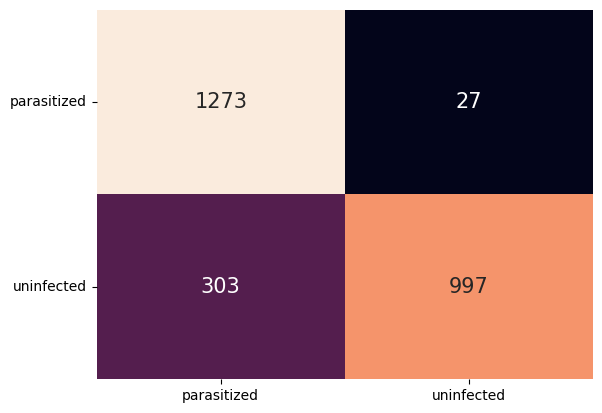

In [198]:
from sklearn.metrics import confusion_matrix

sns.heatmap(
    confusion_matrix(test_image_gen.classes, np.where(y_pred > 0.50, 1, 0)), 
    annot=True, 
    fmt = ".0f", 
    cbar = False, 
    xticklabels=test_image_gen.class_indices.keys(), 
    yticklabels= test_image_gen.class_indices.keys(),
    annot_kws= {"size": 15}
    )
plt.yticks(rotation = 360);